# Exploratory Data Analysis (EDA)

## Team 4 - Data Science Club  
**Product Recommendation Challenge**

This notebook contains comprehensive exploratory data analysis of the Kaggle Product Recommendation Challenge dataset.

**Dataset Structure:**
- `train.csv`: User-item interactions with ratings and timestamps
- `test.csv`: Users for whom we need to make predictions  
- `item_metadata.csv`: Product information including categories, prices, descriptions
- `id_mappings.json`: Mappings between original IDs and encoded numeric IDs
- `sample_submission.csv`: Expected submission format (top 10 item recommendations per user)


## Table of Contents

1. [Import Libraries and Setup](#1-import-libraries-and-setup)
2. [Data Loading and Overview](#2-data-loading-and-overview)
3. [Data Quality Assessment](#3-data-quality-assessment)
4. [Training Data Analysis](#4-training-data-analysis)
   - User-Item Interaction Patterns
   - Rating Distribution Analysis
   - Temporal Analysis (Timestamps)
   - User Behavior Analysis
   - Item Popularity Analysis
5. [Item Metadata Analysis](#5-item-metadata-analysis)
   - Product Categories Distribution
   - Price Analysis
   - Rating Analysis
   - Feature Analysis
6. [ID Mappings Analysis](#6-id-mappings-analysis)
7. [Data Relationships and Correlations](#7-data-relationships-and-correlations)
8. [Cold Start Problem Analysis](#8-cold-start-problem-analysis)
9. [Sparsity Analysis](#9-sparsity-analysis)
10. [Test Set Analysis](#10-test-set-analysis)
11. [Key Insights and Recommendations](#11-key-insights-and-recommendations)


## 1. Import Libraries and Setup


In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import json
from datetime import datetime
import warnings

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Statistical analysis
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.sparse import csr_matrix

# Machine learning utilities
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import cosine_similarity

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Suppress warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")


Libraries imported successfully!


## 2. Data Loading and Overview


In [4]:
# Load all datasets
print("Loading datasets...")

# Training data - user-item interactions with ratings and timestamps
train_df = pd.read_csv('data/train.csv')
print(f"✓ Training data loaded: {train_df.shape}")

# Test data - users for whom we need to make predictions
test_df = pd.read_csv('data/test.csv')
print(f"✓ Test data loaded: {test_df.shape}")

# Sample submission - expected format (user_id: space-separated item recommendations)
sample_submission = pd.read_csv('data/sample_submission.csv')
print(f"✓ Sample submission loaded: {sample_submission.shape}")

# Item metadata - product information
item_metadata = pd.read_csv('data/item_metadata.csv')
print(f"✓ Item metadata loaded: {item_metadata.shape}")

# ID mappings - mappings between original IDs and encoded numeric IDs
with open('data/id_mappings.json', 'r') as f:
    id_mappings = json.load(f)
print(f"✓ ID mappings loaded")

print("\nAll datasets loaded successfully!")


Loading datasets...
✓ Training data loaded: (2543146, 4)
✓ Test data loaded: (412461, 2)
✓ Sample submission loaded: (412461, 2)
✓ Item metadata loaded: (262134, 15)
✓ ID mappings loaded

All datasets loaded successfully!


In [5]:
# Dataset overview
datasets = {
    'Training Data': train_df,
    'Test Data': test_df,
    'Sample Submission': sample_submission,
    'Item Metadata': item_metadata
}

print("=" * 60)
print("DATASET OVERVIEW")
print("=" * 60)

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Shape: {df.shape}")
    print(f"  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"  Columns: {list(df.columns)}")

print(f"\nID Mappings structure:")
for key in id_mappings.keys():
    if isinstance(id_mappings[key], dict):
        print(f"  {key}: {len(id_mappings[key])} mappings")
    else:
        print(f"  {key}: {type(id_mappings[key])}")

# Display first few rows of each dataset
for name, df in datasets.items():
    print(f"\n{name.upper()} - First 5 rows:")
    print("-" * 40)
    display(df.head())


DATASET OVERVIEW

Training Data:
  Shape: (2543146, 4)
  Memory usage: 77.61 MB
  Columns: ['user_id', 'item_id', 'rating', 'timestamp']

Test Data:
  Shape: (412461, 2)
  Memory usage: 6.29 MB
  Columns: ['user_id', 'predictions']

Sample Submission:
  Shape: (412461, 2)
  Memory usage: 48.21 MB
  Columns: ['user_id', 'predictions']

Item Metadata:
  Shape: (262134, 15)
  Memory usage: 816.23 MB
  Columns: ['parent_asin', 'main_category', 'title', 'average_rating', 'rating_number', 'price', 'store', 'features', 'description', 'images', 'categories', 'image_count', 'has_images', 'image_urls', 'category']

ID Mappings structure:
  user_mapping: 868218 mappings
  item_mapping: 77833 mappings
  user_reverse_mapping: 868218 mappings
  item_reverse_mapping: 77833 mappings

TRAINING DATA - First 5 rows:
----------------------------------------


,user_id,item_id,rating,timestamp
0,0,7314,5.0,1353612262000
1,0,15493,5.0,1370653034000
2,0,18817,4.0,1373668644000
3,0,18251,4.0,1373669469000
4,0,16199,1.0,1375136041000



TEST DATA - First 5 rows:
----------------------------------------


,user_id,predictions
0,0,0
1,1,0
2,3,0
3,5,0
4,6,0



SAMPLE SUBMISSION - First 5 rows:
----------------------------------------


,user_id,predictions
0,0,50727 25161 70745 64522 3476 5270 67819 59047 ...
1,1,72042 48322 70607 51973 13888 45212 47281 1675...
2,3,9089 12890 75010 54531 32877 16323 61681 47577...
3,5,69577 62092 71413 11696 50124 68857 59313 1941...
4,6,17948 74726 76760 12812 59042 33294 16508 7463...



ITEM METADATA - First 5 rows:
----------------------------------------


,parent_asin,main_category,title,average_rating,rating_number,price,store,features,description,images,categories,image_count,has_images,image_urls,category
0,B01CUPMQZE,All Beauty,"Howard LC0008 Leather Conditioner, 8-Ounce (4-...",4.8,10.0,NaN,Howard Products,[],[],"{'hi_res': array([None,\n 'https://m.med...",[],5,True,['https://m.media-amazon.com/images/I/71i77AuI...,All_Beauty
1,B076WQZGPM,All Beauty,Yes to Tomatoes Detoxifying Charcoal Cleanser ...,4.5,3.0,NaN,Yes To,[],[],{'hi_res': array(['https://m.media-amazon.com/...,[],6,True,['https://m.media-amazon.com/images/I/71g1lP0p...,All_Beauty
2,B000B658RI,All Beauty,Eye Patch Black Adult with Tie Band (6 Per Pack),4.4,26.0,NaN,Levine Health Products,[],[],"{'hi_res': array([None, None], dtype=object), ...",[],4,True,['https://m.media-amazon.com/images/I/31bz+uqz...,All_Beauty
3,B088FKY3VD,All Beauty,"Tattoo Eyebrow Stickers, Waterproof Eyebrow, 4...",3.1,102.0,NaN,Cherioll,[],[],{'hi_res': array(['https://m.media-amazon.com/...,[],21,True,['https://m.media-amazon.com/images/I/71GJhXQG...,All_Beauty
4,B07NGFDN6G,All Beauty,Precision Plunger Bars for Cartridge Grips – 9...,4.3,7.0,NaN,Precision,['Material: 304 Stainless Steel; Brass tip'\n ...,['The Precision Plunger Bars are designed to w...,"{'hi_res': array([None], dtype=object), 'large...",[],2,True,['https://m.media-amazon.com/images/I/31TgqAZ8...,All_Beauty


## 3. Data Quality Assessment

In [6]:
# Missing values analysis
def analyze_missing_values(df, name):
    print(f"\n{name}:")
    print("-" * 30)
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    
    if missing.sum() == 0:
        print("✓ No missing values found!")
    else:
        missing_df = pd.DataFrame({
            'Missing Count': missing,
            'Missing Percentage': missing_pct.round(2)
        }).sort_values('Missing Count', ascending=False)
        
        display(missing_df[missing_df['Missing Count'] > 0])

print("=" * 60)
print("MISSING VALUES ANALYSIS")
print("=" * 60)

for name, df in datasets.items():
    analyze_missing_values(df, name)


MISSING VALUES ANALYSIS

Training Data:
------------------------------
✓ No missing values found!

Test Data:
------------------------------
✓ No missing values found!

Sample Submission:
------------------------------
✓ No missing values found!

Item Metadata:
------------------------------


,Missing Count,Missing Percentage
price,162909,62.15
store,13921,5.31
rating_number,2959,1.13
main_category,1769,0.67
average_rating,25,0.01
title,17,0.01


Creating rating distribution bar chart...


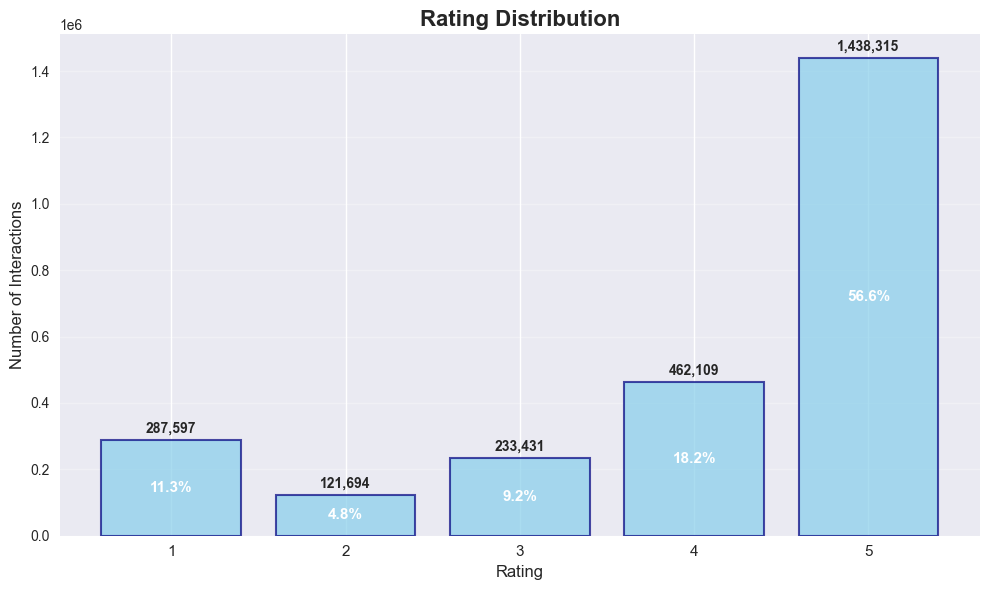


Rating Distribution Summary:
Most common rating: 5.0 (appeared 1,438,315 times)
Least common rating: 2.0 (appeared 121,694 times)
Total interactions: 2,543,146
Average rating: 4.04
Median rating: 5.0


In [13]:
# Rating Distribution Bar Chart
print("Creating rating distribution bar chart...")

# Get rating counts
rating_counts = train_df['rating'].value_counts().sort_index()

# Create bar chart for rating distribution
plt.figure(figsize=(10, 6))
bars = plt.bar(rating_counts.index, rating_counts.values, 
               color='skyblue', alpha=0.7, edgecolor='navy', linewidth=1.5)

plt.title('Rating Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Interactions', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels on top of bars
for bar, value in zip(bars, rating_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(rating_counts.values)*0.01, 
             f'{value:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Add percentage labels inside bars
total_interactions = rating_counts.sum()
for bar, value in zip(bars, rating_counts.values):
    percentage = (value / total_interactions) * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
             f'{percentage:.1f}%', ha='center', va='center', 
             fontweight='bold', color='white', fontsize=11)

# Enhance the plot appearance
plt.xticks(rating_counts.index, fontsize=11)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Display summary statistics
print("\nRating Distribution Summary:")
print(f"Most common rating: {rating_counts.idxmax()} (appeared {rating_counts.max():,} times)")
print(f"Least common rating: {rating_counts.idxmin()} (appeared {rating_counts.min():,} times)")
print(f"Total interactions: {total_interactions:,}")
print(f"Average rating: {train_df['rating'].mean():.2f}")
print(f"Median rating: {train_df['rating'].median():.1f}")


In [7]:
# Duplicate analysis
print("=" * 60)
print("DUPLICATE ANALYSIS")
print("=" * 60)

for name, df in datasets.items():
    duplicates = df.duplicated().sum()
    print(f"{name}: {duplicates} duplicate rows ({duplicates/len(df)*100:.2f}%)")

# Data types analysis
print("\n" + "=" * 60)
print("DATA TYPES ANALYSIS")
print("=" * 60)

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Data types: {df.dtypes.value_counts().to_dict()}")
    
    # Identify potential issues
    object_cols = df.select_dtypes(include=['object']).columns
    if len(object_cols) > 0:
        print(f"  Text columns: {list(object_cols)}")
        
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        print(f"  Numeric columns: {list(numeric_cols)}")


DUPLICATE ANALYSIS
Training Data: 0 duplicate rows (0.00%)
Test Data: 0 duplicate rows (0.00%)
Sample Submission: 0 duplicate rows (0.00%)
Item Metadata: 0 duplicate rows (0.00%)

DATA TYPES ANALYSIS

Training Data:
  Data types: {dtype('int64'): 3, dtype('float64'): 1}
  Numeric columns: ['user_id', 'item_id', 'rating', 'timestamp']

Test Data:
  Data types: {dtype('int64'): 2}
  Numeric columns: ['user_id', 'predictions']

Sample Submission:
  Data types: {dtype('int64'): 1, dtype('O'): 1}
  Text columns: ['predictions']
  Numeric columns: ['user_id']

Item Metadata:
  Data types: {dtype('O'): 10, dtype('float64'): 3, dtype('int64'): 1, dtype('bool'): 1}
  Text columns: ['parent_asin', 'main_category', 'title', 'store', 'features', 'description', 'images', 'categories', 'image_urls', 'category']
  Numeric columns: ['average_rating', 'rating_number', 'price', 'image_count']


## 4. Training Data Analysis

### 4.1 User-Item Interaction Patterns


In [12]:
# Basic statistics about training data
print("=" * 60)
print("TRAINING DATA BASIC STATISTICS")
print("=" * 60)

print(f"Training data shape: {train_df.shape}")
print(f"Number of unique users: {train_df['user_id'].nunique():,}")
print(f"Number of unique items: {train_df['item_id'].nunique():,}")
print(f"Number of interactions: {len(train_df):,}")
print(f"Date range: {pd.to_datetime(train_df['timestamp'], unit='ms').min()} to {pd.to_datetime(train_df['timestamp'], unit='ms').max()}")

# Statistical summary
print(f"\nStatistical summary:")
display(train_df.describe())

# Rating distribution
print(f"\nRating distribution:")
display(train_df['rating'].value_counts().sort_index())




TRAINING DATA BASIC STATISTICS
Training data shape: (2543146, 4)
Number of unique users: 868,218
Number of unique items: 76,747
Number of interactions: 2,543,146
Date range: 2000-04-24 15:01:15 to 2023-09-11 02:06:49.121000

Statistical summary:


,user_id,item_id,rating,timestamp
count,2.543146e+06,2.543146e+06,2.543146e+06,2.543146e+06
mean,4.338789e+05,2.840569e+04,4.038812e+00,1.467106e+12
std,2.509318e+05,1.796797e+04,1.365664e+00,8.242910e+10
min,0.000000e+00,0.000000e+00,1.000000e+00,9.565885e+11
25%,2.163772e+05,1.345100e+04,3.000000e+00,1.407054e+12
50%,4.337430e+05,2.493100e+04,5.000000e+00,1.453042e+12
75%,6.512078e+05,4.029700e+04,5.000000e+00,1.523213e+12
max,8.682170e+05,7.783200e+04,5.000000e+00,1.694398e+12



Rating distribution:


rating
1.0     287597
2.0     121694
3.0     233431
4.0     462109
5.0    1438315
Name: count, dtype: int64

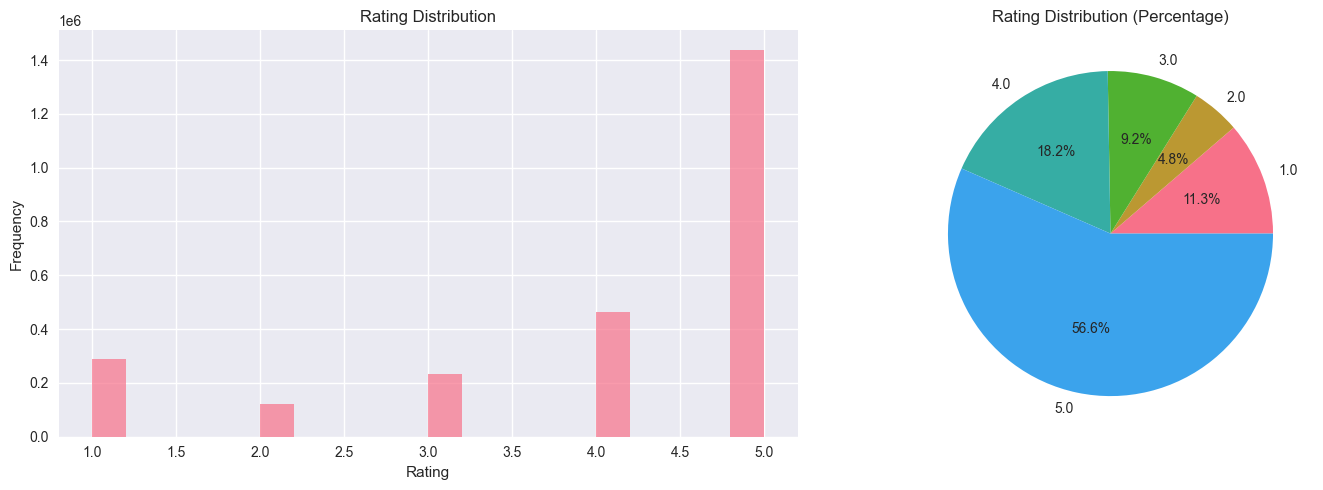

Rating Statistics:
Mean rating: 4.04
Median rating: 5.00
Mode rating: 5.0
Standard deviation: 1.37


In [14]:
# Visualize rating distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Rating distribution histogram
train_df['rating'].hist(bins=20, ax=axes[0], alpha=0.7)
axes[0].set_title('Rating Distribution')
axes[0].set_xlabel('Rating')
axes[0].set_ylabel('Frequency')

# Rating distribution pie chart
rating_counts = train_df['rating'].value_counts().sort_index()
axes[1].pie(rating_counts.values, labels=rating_counts.index, autopct='%1.1f%%')
axes[1].set_title('Rating Distribution (Percentage)')

plt.tight_layout()
plt.show()

# Rating statistics
print("Rating Statistics:")
print(f"Mean rating: {train_df['rating'].mean():.2f}")
print(f"Median rating: {train_df['rating'].median():.2f}")
print(f"Mode rating: {train_df['rating'].mode().iloc[0]:.1f}")
print(f"Standard deviation: {train_df['rating'].std():.2f}")


### 4.2 User Behavior Analysis


USER BEHAVIOR ANALYSIS
User interaction statistics:


,user_id,num_interactions,avg_rating,rating_std,min_rating,max_rating
count,868218.000000,868218.000000,868218.000000,868218.000000,868218.000000,868218.000000
mean,434108.500000,2.929156,4.048830,0.762665,3.375346,4.624402
std,250633.092345,3.067941,1.054393,0.878970,1.569433,0.885361
min,0.000000,2.000000,1.000000,0.000000,1.000000,1.000000
25%,217054.250000,2.000000,3.500000,0.000000,2.000000,5.000000
50%,434108.500000,2.000000,4.500000,0.630000,4.000000,5.000000
75%,651162.750000,3.000000,5.000000,1.410000,5.000000,5.000000
max,868217.000000,284.000000,5.000000,2.830000,5.000000,5.000000


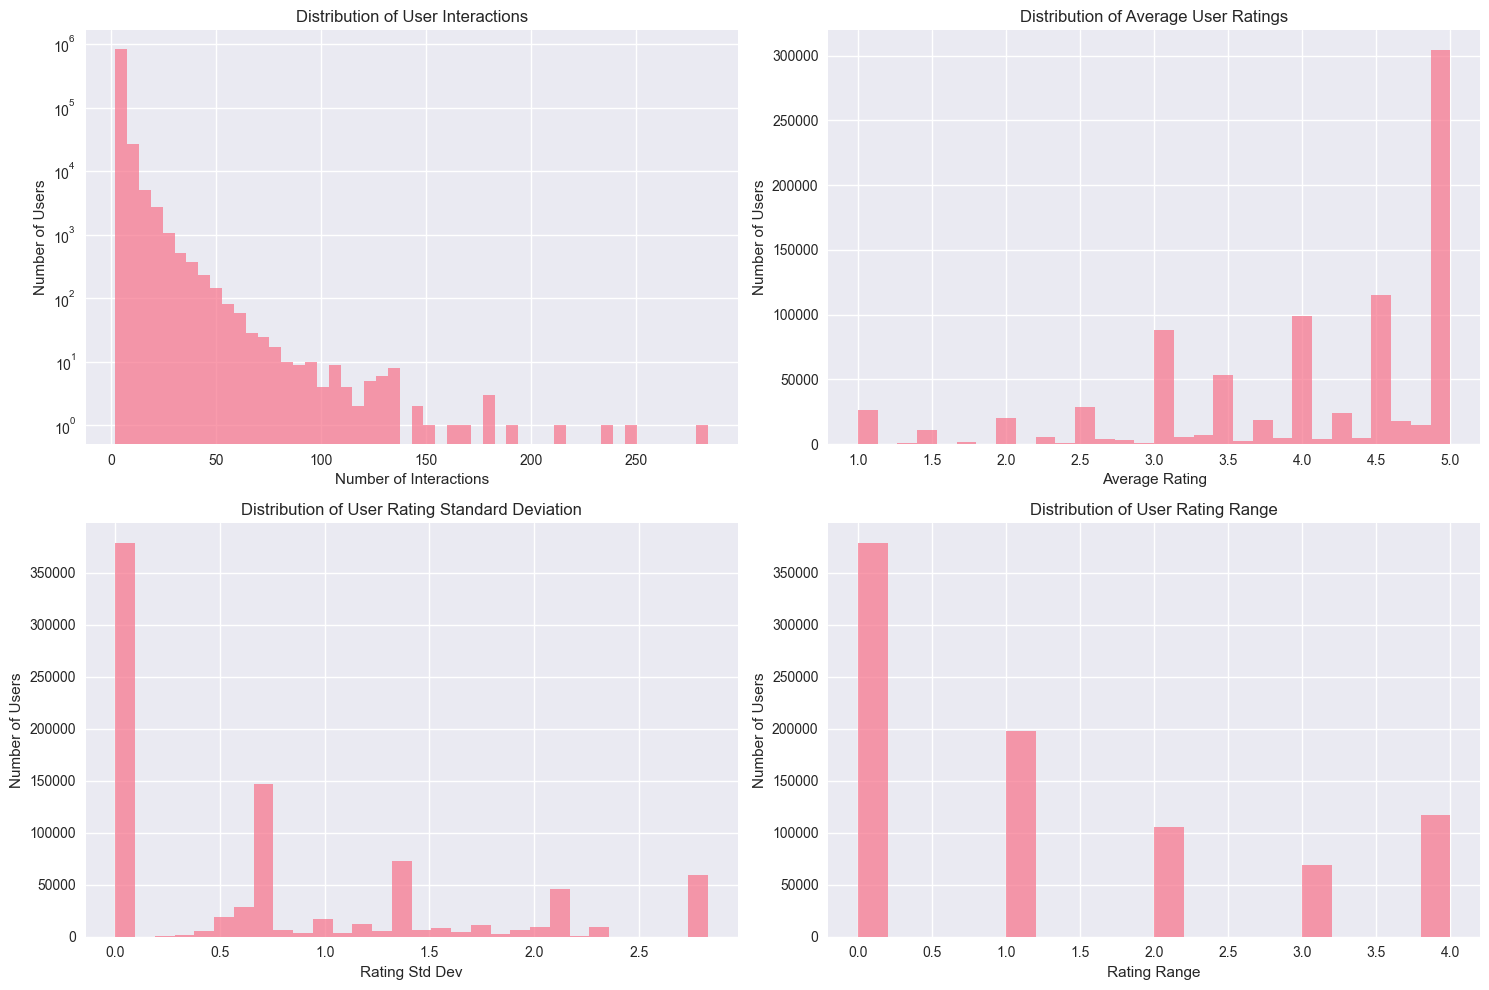

In [15]:
# User activity analysis
user_stats = train_df.groupby('user_id').agg({
    'item_id': 'count',
    'rating': ['mean', 'std', 'min', 'max']
}).round(2)

user_stats.columns = ['num_interactions', 'avg_rating', 'rating_std', 'min_rating', 'max_rating']
user_stats = user_stats.reset_index()

print("=" * 60)
print("USER BEHAVIOR ANALYSIS")
print("=" * 60)

print("User interaction statistics:")
display(user_stats.describe())

# Visualize user activity distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Number of interactions per user
axes[0,0].hist(user_stats['num_interactions'], bins=50, alpha=0.7)
axes[0,0].set_title('Distribution of User Interactions')
axes[0,0].set_xlabel('Number of Interactions')
axes[0,0].set_ylabel('Number of Users')
axes[0,0].set_yscale('log')

# Average rating per user
axes[0,1].hist(user_stats['avg_rating'], bins=30, alpha=0.7)
axes[0,1].set_title('Distribution of Average User Ratings')
axes[0,1].set_xlabel('Average Rating')
axes[0,1].set_ylabel('Number of Users')

# Rating standard deviation per user
axes[1,0].hist(user_stats['rating_std'].dropna(), bins=30, alpha=0.7)
axes[1,0].set_title('Distribution of User Rating Standard Deviation')
axes[1,0].set_xlabel('Rating Std Dev')
axes[1,0].set_ylabel('Number of Users')

# Rating range per user
user_stats['rating_range'] = user_stats['max_rating'] - user_stats['min_rating']
axes[1,1].hist(user_stats['rating_range'], bins=20, alpha=0.7)
axes[1,1].set_title('Distribution of User Rating Range')
axes[1,1].set_xlabel('Rating Range')
axes[1,1].set_ylabel('Number of Users')

plt.tight_layout()
plt.show()


### 4.3 Item Popularity Analysis


ITEM POPULARITY ANALYSIS
Item interaction statistics:


,item_id,num_interactions,avg_rating,rating_std,min_rating,max_rating
count,76747.000000,76747.000000,76747.000000,68855.000000,76747.000000,76747.000000
mean,38699.191578,33.136748,3.647633,1.200436,2.286891,4.574876
std,22441.189606,316.613855,1.106920,0.771237,1.582211,1.033780
min,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,19241.500000,2.000000,3.000000,0.710000,1.000000,5.000000
50%,38611.000000,3.000000,3.850000,1.340000,1.000000,5.000000
75%,58115.500000,8.000000,4.500000,1.730000,4.000000,5.000000
max,77832.000000,28303.000000,5.000000,2.830000,5.000000,5.000000



Top 10 most popular items (by number of interactions):


,item_id,num_interactions,avg_rating,rating_std,min_rating,max_rating
20768,20832,28303,4.33,1.09,1.0,5.0
12570,12595,22787,4.54,1.02,1.0,5.0
12348,12372,16378,3.50,1.62,1.0,5.0
6849,6864,15428,4.34,1.20,1.0,5.0
32988,33154,14792,4.62,0.90,1.0,5.0
13423,13451,13007,4.58,0.90,1.0,5.0
7015,7030,12306,4.45,0.94,1.0,5.0
24848,24931,12188,4.39,1.10,1.0,5.0
18498,18550,11628,4.36,1.17,1.0,5.0
12080,12104,11551,4.53,1.00,1.0,5.0



Top 10 highest rated items (min 10 interactions):


,item_id,num_interactions,avg_rating,rating_std,min_rating,max_rating
2075,2078,13,5.0,0.0,5.0,5.0
5662,5672,20,5.0,0.0,5.0,5.0
8171,8188,13,5.0,0.0,5.0,5.0
8208,8225,10,5.0,0.0,5.0,5.0
9648,9668,10,5.0,0.0,5.0,5.0
10695,10717,11,5.0,0.0,5.0,5.0
11797,11821,18,5.0,0.0,5.0,5.0
11999,12023,14,5.0,0.0,5.0,5.0
13197,13225,14,5.0,0.0,5.0,5.0
18012,18062,10,5.0,0.0,5.0,5.0


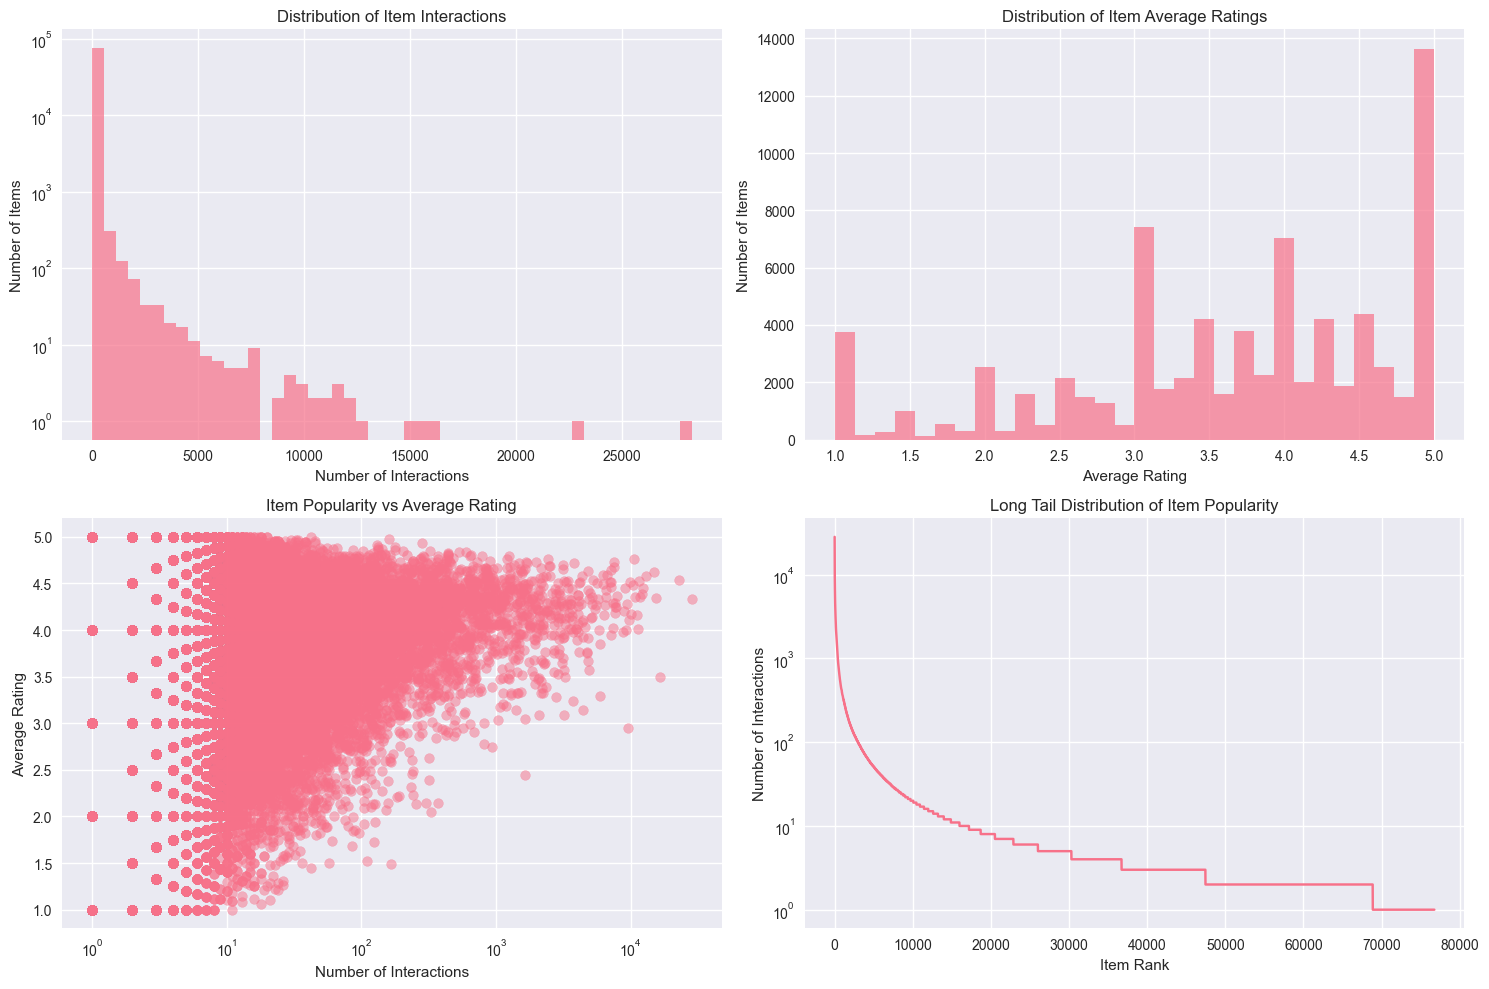

In [16]:
# Item popularity analysis
item_stats = train_df.groupby('item_id').agg({
    'user_id': 'count',
    'rating': ['mean', 'std', 'min', 'max']
}).round(2)

item_stats.columns = ['num_interactions', 'avg_rating', 'rating_std', 'min_rating', 'max_rating']
item_stats = item_stats.reset_index()

print("=" * 60)
print("ITEM POPULARITY ANALYSIS")
print("=" * 60)

print("Item interaction statistics:")
display(item_stats.describe())

# Most popular items
print("\nTop 10 most popular items (by number of interactions):")
top_items = item_stats.nlargest(10, 'num_interactions')
display(top_items)

# Highest rated items (with minimum interactions)
min_interactions = 10
highly_rated = item_stats[item_stats['num_interactions'] >= min_interactions].nlargest(10, 'avg_rating')
print(f"\nTop 10 highest rated items (min {min_interactions} interactions):")
display(highly_rated)

# Visualize item popularity
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Item interaction distribution
axes[0,0].hist(item_stats['num_interactions'], bins=50, alpha=0.7)
axes[0,0].set_title('Distribution of Item Interactions')
axes[0,0].set_xlabel('Number of Interactions')
axes[0,0].set_ylabel('Number of Items')
axes[0,0].set_yscale('log')

# Item average rating distribution
axes[0,1].hist(item_stats['avg_rating'], bins=30, alpha=0.7)
axes[0,1].set_title('Distribution of Item Average Ratings')
axes[0,1].set_xlabel('Average Rating')
axes[0,1].set_ylabel('Number of Items')

# Scatter plot: popularity vs rating
axes[1,0].scatter(item_stats['num_interactions'], item_stats['avg_rating'], alpha=0.5)
axes[1,0].set_title('Item Popularity vs Average Rating')
axes[1,0].set_xlabel('Number of Interactions')
axes[1,0].set_ylabel('Average Rating')
axes[1,0].set_xscale('log')

# Long tail analysis
item_counts = item_stats['num_interactions'].sort_values(ascending=False)
axes[1,1].plot(range(len(item_counts)), item_counts.values)
axes[1,1].set_title('Long Tail Distribution of Item Popularity')
axes[1,1].set_xlabel('Item Rank')
axes[1,1].set_ylabel('Number of Interactions')
axes[1,1].set_yscale('log')

plt.tight_layout()
plt.show()


### 4.4 Temporal Analysis


TEMPORAL ANALYSIS


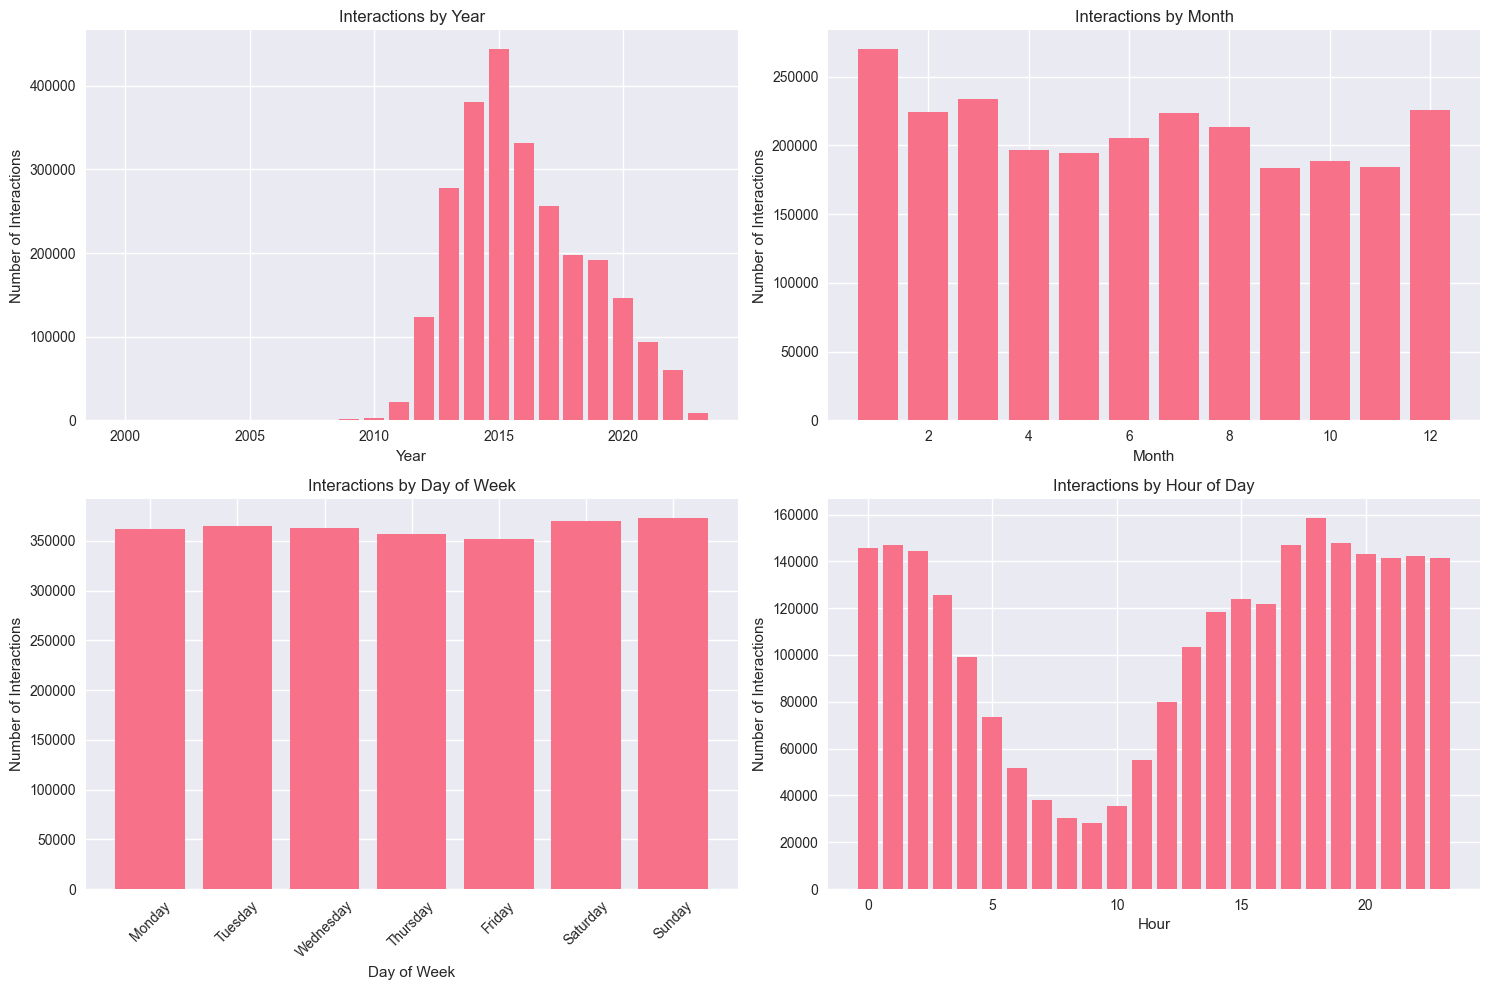

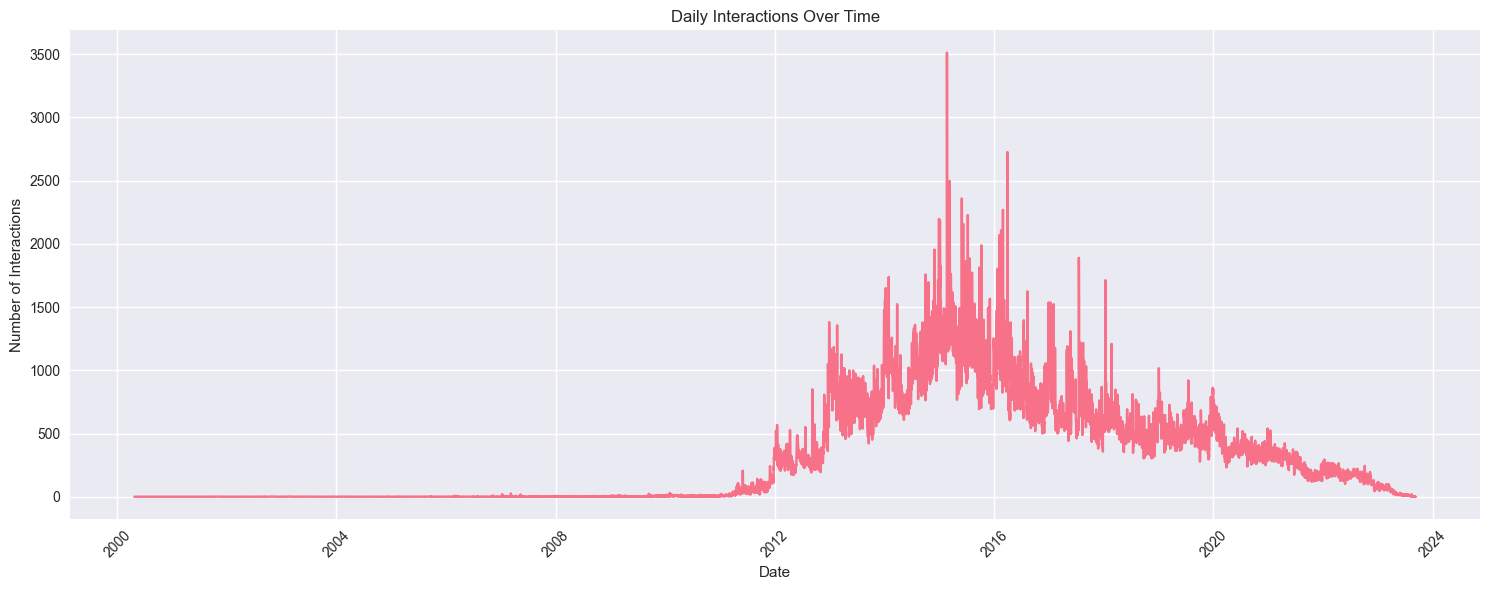

In [17]:
# Convert timestamp to datetime
train_df['datetime'] = pd.to_datetime(train_df['timestamp'], unit='ms')
train_df['date'] = train_df['datetime'].dt.date
train_df['year'] = train_df['datetime'].dt.year
train_df['month'] = train_df['datetime'].dt.month
train_df['day_of_week'] = train_df['datetime'].dt.day_name()
train_df['hour'] = train_df['datetime'].dt.hour

print("=" * 60)
print("TEMPORAL ANALYSIS")
print("=" * 60)

# Interactions over time
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Interactions by year
yearly_counts = train_df['year'].value_counts().sort_index()
axes[0,0].bar(yearly_counts.index, yearly_counts.values)
axes[0,0].set_title('Interactions by Year')
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Number of Interactions')

# Interactions by month
monthly_counts = train_df['month'].value_counts().sort_index()
axes[0,1].bar(monthly_counts.index, monthly_counts.values)
axes[0,1].set_title('Interactions by Month')
axes[0,1].set_xlabel('Month')
axes[0,1].set_ylabel('Number of Interactions')

# Interactions by day of week
dow_counts = train_df['day_of_week'].value_counts()
dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_counts = dow_counts.reindex(dow_order)
axes[1,0].bar(range(len(dow_counts)), dow_counts.values)
axes[1,0].set_title('Interactions by Day of Week')
axes[1,0].set_xlabel('Day of Week')
axes[1,0].set_ylabel('Number of Interactions')
axes[1,0].set_xticks(range(len(dow_counts)))
axes[1,0].set_xticklabels(dow_counts.index, rotation=45)

# Interactions by hour
hourly_counts = train_df['hour'].value_counts().sort_index()
axes[1,1].bar(hourly_counts.index, hourly_counts.values)
axes[1,1].set_title('Interactions by Hour of Day')
axes[1,1].set_xlabel('Hour')
axes[1,1].set_ylabel('Number of Interactions')

plt.tight_layout()
plt.show()

# Time series plot
daily_interactions = train_df.groupby('date').size()
plt.figure(figsize=(15, 6))
plt.plot(daily_interactions.index, daily_interactions.values)
plt.title('Daily Interactions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Interactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## 5. Item Metadata Analysis


ITEM METADATA ANALYSIS
Item metadata shape: (262134, 15)
Columns: ['parent_asin', 'main_category', 'title', 'average_rating', 'rating_number', 'price', 'store', 'features', 'description', 'images', 'categories', 'image_count', 'has_images', 'image_urls', 'category']

Metadata column statistics:
parent_asin: object - 262134 unique values
main_category: object - 11 unique values
title: object - 254925 unique values
average_rating: float64 - 41 unique values
rating_number: float64 - 3948 unique values
price: float64 - 5217 unique values
store: object - 85781 unique values
features: object - 104300 unique values
description: object - 114930 unique values
images: object - 253434 unique values
categories: object - 344 unique values
image_count: int64 - 75 unique values
has_images: bool - 2 unique values
image_urls: object - 253410 unique values
category: object - 3 unique values

Top 10 main categories:


main_category
All Beauty                112135
Appstore for Android       68679
Health & Personal Care     60293
Software                   18791
Premium Beauty               455
Gift Cards                     4
Computers                      2
Home Audio & Theater           2
Books                          2
AMAZON FASHION                 1
Name: count, dtype: int64

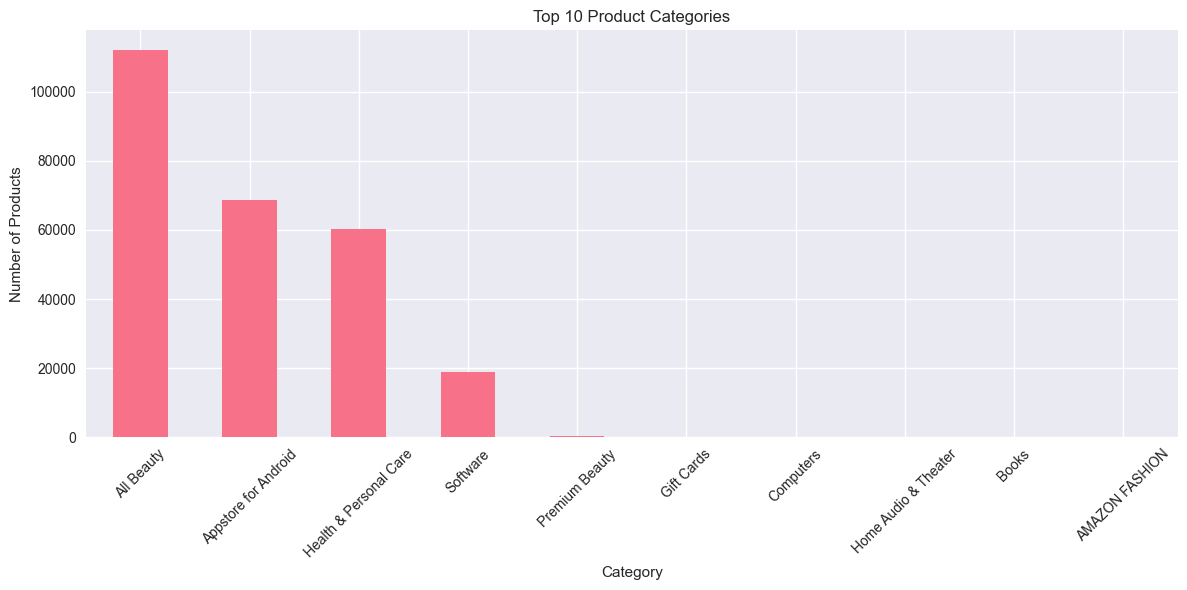


Price analysis:
count    99225.000000
mean        11.622368
std         64.348711
min          0.000000
25%          0.000000
50%          0.000000
75%          9.990000
max       4449.000000
Name: price_numeric, dtype: float64


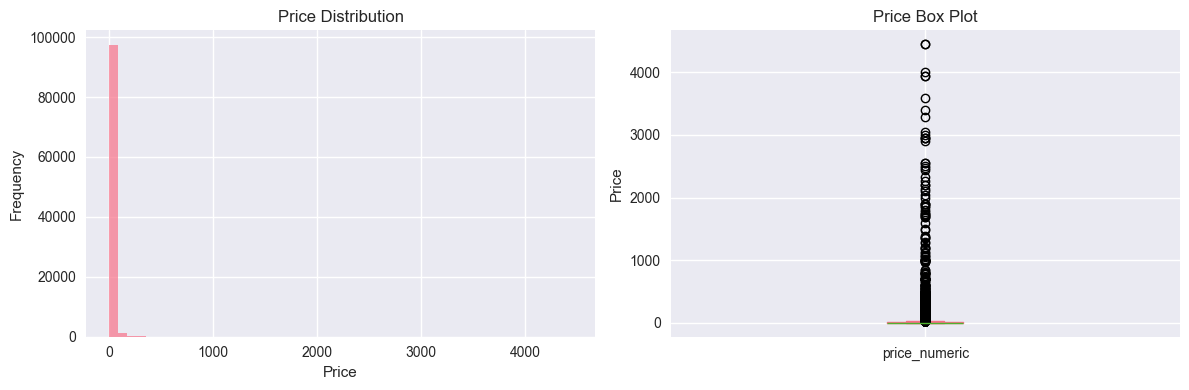


Metadata rating analysis:
count    262109.000000
mean          3.725916
std           0.889219
min           1.000000
25%           3.200000
50%           3.800000
75%           4.400000
max           5.000000
Name: average_rating, dtype: float64


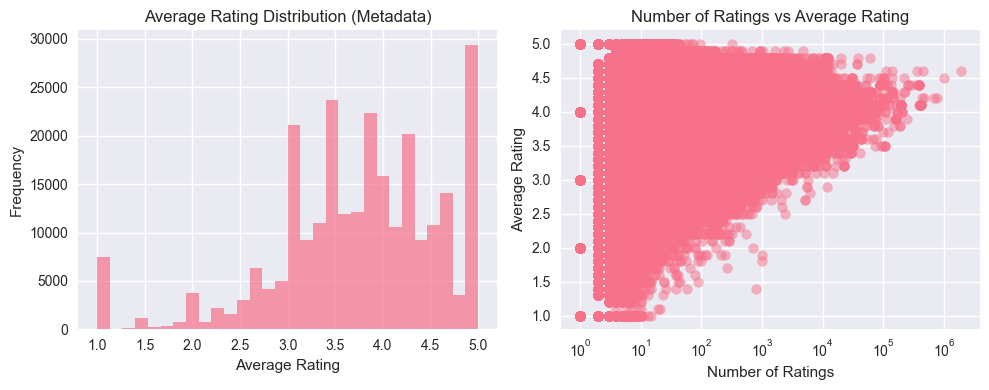

In [18]:
# Item metadata overview
print("=" * 60)
print("ITEM METADATA ANALYSIS")
print("=" * 60)

print(f"Item metadata shape: {item_metadata.shape}")
print(f"Columns: {list(item_metadata.columns)}")

# Display basic info about metadata
print("\nMetadata column statistics:")
for col in item_metadata.columns:
    print(f"{col}: {item_metadata[col].dtype} - {item_metadata[col].nunique()} unique values")

# Category analysis
print("\nTop 10 main categories:")
if 'main_category' in item_metadata.columns:
    category_counts = item_metadata['main_category'].value_counts().head(10)
    display(category_counts)
    
    # Visualize categories
    plt.figure(figsize=(12, 6))
    category_counts.plot(kind='bar')
    plt.title('Top 10 Product Categories')
    plt.xlabel('Category')
    plt.ylabel('Number of Products')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Price analysis
if 'price' in item_metadata.columns:
    print("\nPrice analysis:")
    # Convert price to numeric (handle 'None' values)
    item_metadata['price_numeric'] = pd.to_numeric(item_metadata['price'], errors='coerce')
    price_stats = item_metadata['price_numeric'].describe()
    print(price_stats)
    
    # Price distribution
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    item_metadata['price_numeric'].dropna().hist(bins=50, alpha=0.7)
    plt.title('Price Distribution')
    plt.xlabel('Price')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    item_metadata['price_numeric'].dropna().plot(kind='box')
    plt.title('Price Box Plot')
    plt.ylabel('Price')
    
    plt.tight_layout()
    plt.show()

# Rating analysis in metadata
if 'average_rating' in item_metadata.columns:
    print("\nMetadata rating analysis:")
    rating_stats = item_metadata['average_rating'].describe()
    print(rating_stats)
    
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    item_metadata['average_rating'].hist(bins=30, alpha=0.7)
    plt.title('Average Rating Distribution (Metadata)')
    plt.xlabel('Average Rating')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    if 'rating_number' in item_metadata.columns:
        plt.scatter(item_metadata['rating_number'], item_metadata['average_rating'], alpha=0.5)
        plt.title('Number of Ratings vs Average Rating')
        plt.xlabel('Number of Ratings')
        plt.ylabel('Average Rating')
        plt.xscale('log')
    
    plt.tight_layout()
    plt.show()


## 6. ID Mappings Analysis


In [19]:
# ID mappings analysis
print("=" * 60)
print("ID MAPPINGS ANALYSIS")
print("=" * 60)

# Analyze mapping structure
for key, value in id_mappings.items():
    if isinstance(value, dict):
        print(f"\n{key}:")
        print(f"  Number of mappings: {len(value)}")
        if len(value) > 0:
            # Show sample mappings
            sample_keys = list(value.keys())[:5]
            print(f"  Sample mappings:")
            for sample_key in sample_keys:
                print(f"    {sample_key} -> {value[sample_key]}")
    else:
        print(f"\n{key}: {type(value)}")

# Check consistency between datasets and mappings
print("\n" + "=" * 40)
print("CONSISTENCY CHECK")
print("=" * 40)

if 'user_mapping' in id_mappings:
    mapped_users = set(id_mappings['user_mapping'].values())
    train_users = set(train_df['user_id'].unique())
    test_users = set(test_df['user_id'].unique())
    
    print(f"Mapped users: {len(mapped_users)}")
    print(f"Training users: {len(train_users)}")
    print(f"Test users: {len(test_users)}")
    print(f"Overlap train-test: {len(train_users.intersection(test_users))}")

if 'item_mapping' in id_mappings:
    mapped_items = set(id_mappings['item_mapping'].values())
    train_items = set(train_df['item_id'].unique())
    metadata_items = set(item_metadata.index) if 'parent_asin' in item_metadata.columns else set()
    
    print(f"Mapped items: {len(mapped_items)}")
    print(f"Training items: {len(train_items)}")
    print(f"Metadata items: {len(metadata_items)}")
    print(f"Items in both train and metadata: {len(train_items.intersection(metadata_items))}")


ID MAPPINGS ANALYSIS

user_mapping:
  Number of mappings: 868218
  Sample mappings:
    AE22236AFRRSMQIKGG7TPTB75QEA -> 0
    AE2224FSUK5AV5R2USYXINUNTW7Q -> 1
    AE2226PENZTTCDKFGRTUCUX2NU2Q -> 2
    AE2227QSJSF6HV3XTTIGQAPA6WHQ -> 3
    AE222DQMT4CHUOINFJDEIYWZJHJQ -> 4

item_mapping:
  Number of mappings: 77833
  Sample mappings:
    0007931727 -> 0
    0321700945 -> 1
    0321719816 -> 2
    0321719824 -> 3
    0321898338 -> 4

user_reverse_mapping:
  Number of mappings: 868218
  Sample mappings:
    0 -> AE22236AFRRSMQIKGG7TPTB75QEA
    1 -> AE2224FSUK5AV5R2USYXINUNTW7Q
    2 -> AE2226PENZTTCDKFGRTUCUX2NU2Q
    3 -> AE2227QSJSF6HV3XTTIGQAPA6WHQ
    4 -> AE222DQMT4CHUOINFJDEIYWZJHJQ

item_reverse_mapping:
  Number of mappings: 77833
  Sample mappings:
    0 -> 0007931727
    1 -> 0321700945
    2 -> 0321719816
    3 -> 0321719824
    4 -> 0321898338

CONSISTENCY CHECK
Mapped users: 868218
Training users: 868218
Test users: 412461
Overlap train-test: 412461
Mapped items: 77833
Trai

## 7. Data Relationships and Correlations


DATA RELATIONSHIPS AND CORRELATIONS
Training data with metadata: (2543146, 27)
Successful merges: 2543146


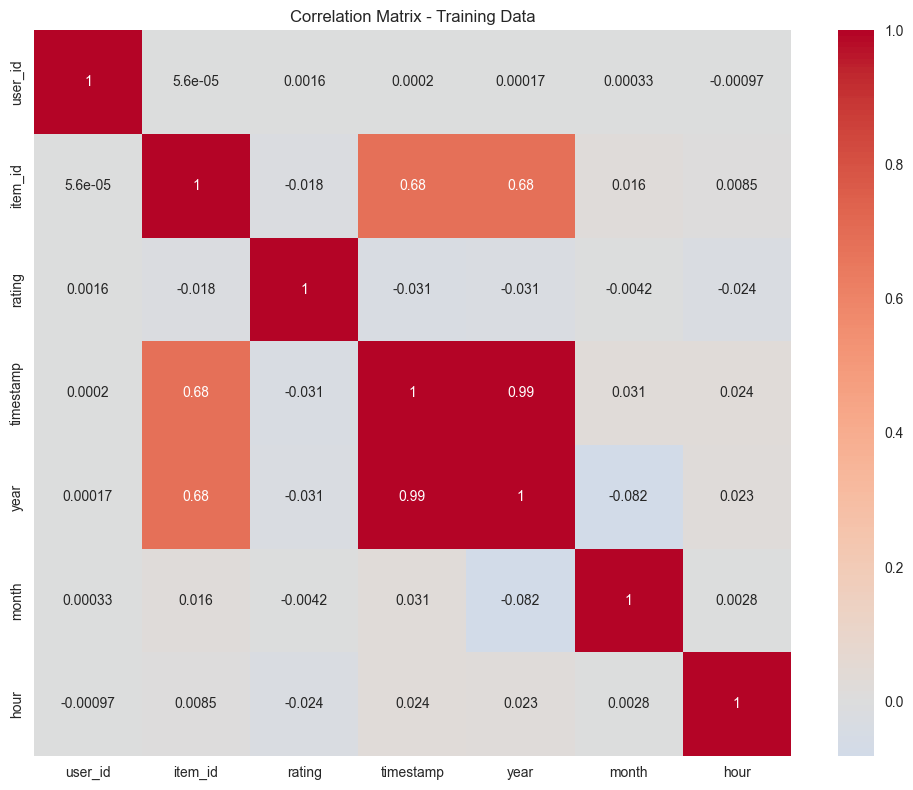


Rating patterns by category:


,mean,count,std
main_category,,,
Premium Beauty,4.20,813,1.34
Health & Personal Care,4.14,59839,1.36
All Beauty,4.09,81010,1.38
Appstore for Android,4.04,2298512,1.36
Software,3.94,102099,1.46


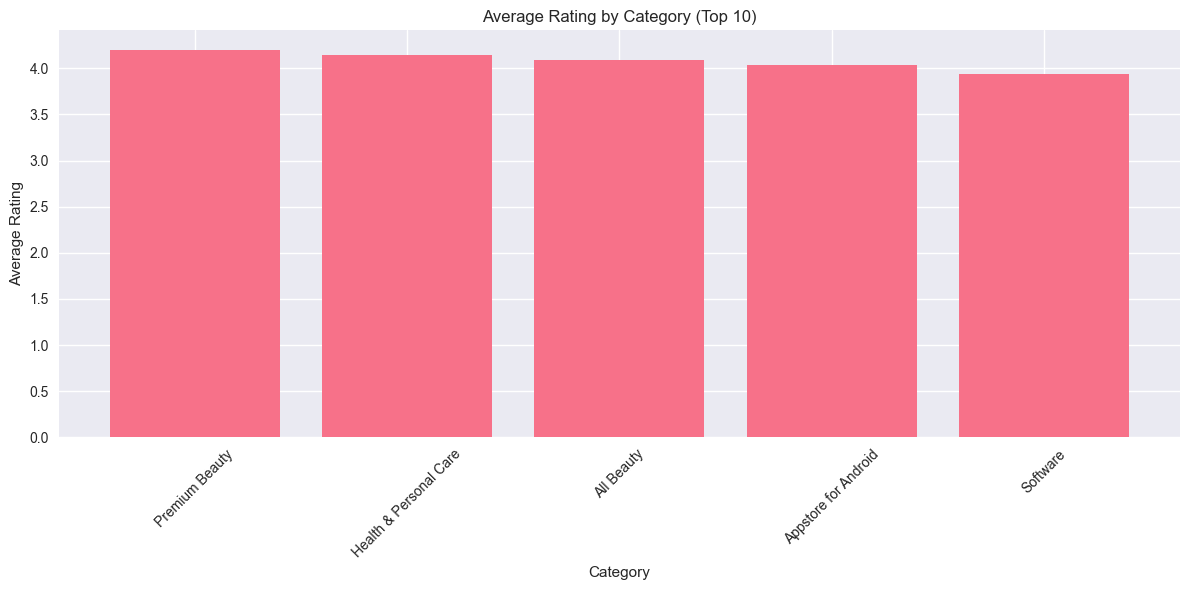

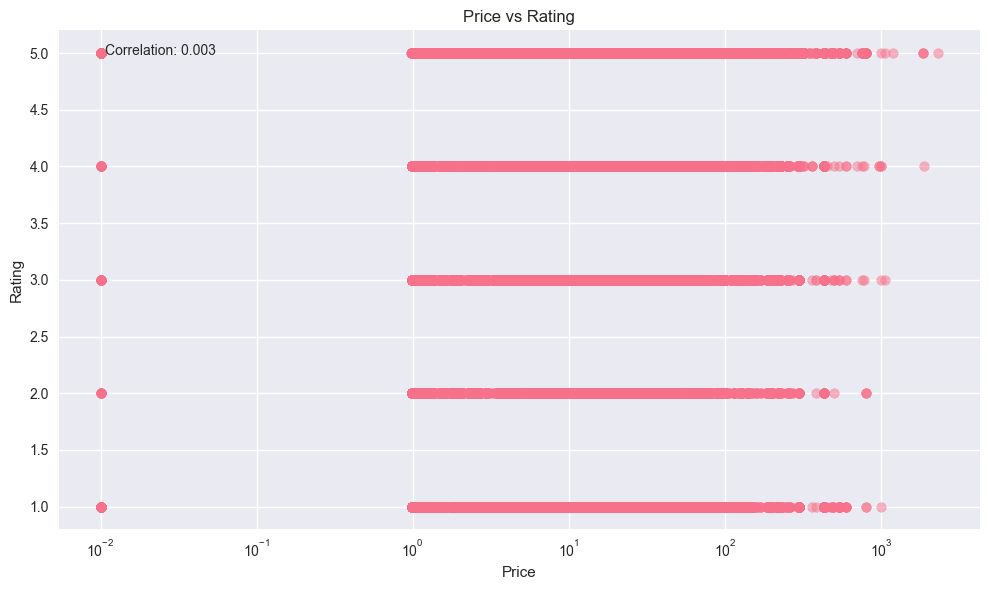

In [20]:
# Analyze relationships between features
print("=" * 60)
print("DATA RELATIONSHIPS AND CORRELATIONS")
print("=" * 60)

# Merge training data with item metadata for analysis
# First, create a mapping from item_id to metadata index
if 'parent_asin' in item_metadata.columns:
    # Create reverse item mapping
    reverse_item_mapping = {v: k for k, v in id_mappings.get('item_mapping', {}).items()}
    
    # Add original ASIN to train data
    train_df['item_asin'] = train_df['item_id'].map(reverse_item_mapping)
    
    # Merge with metadata
    train_with_metadata = train_df.merge(
        item_metadata,
        left_on='item_asin',
        right_on='parent_asin',
        how='left'
    )
    
    print(f"Training data with metadata: {train_with_metadata.shape}")
    print(f"Successful merges: {train_with_metadata['parent_asin'].notna().sum()}")

# Correlation analysis
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
if len(numeric_cols) > 1:
    plt.figure(figsize=(10, 8))
    correlation_matrix = train_df[numeric_cols].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix - Training Data')
    plt.tight_layout()
    plt.show()

# Analyze rating patterns by category (if metadata available)
if 'main_category' in item_metadata.columns and 'train_with_metadata' in locals():
    print("\nRating patterns by category:")
    category_ratings = train_with_metadata.groupby('main_category')['rating'].agg(['mean', 'count', 'std']).round(2)
    category_ratings = category_ratings[category_ratings['count'] >= 100]  # Filter categories with enough data
    category_ratings = category_ratings.sort_values('mean', ascending=False)
    display(category_ratings.head(10))
    
    # Visualize
    plt.figure(figsize=(12, 6))
    top_categories = category_ratings.head(10)
    plt.bar(range(len(top_categories)), top_categories['mean'])
    plt.title('Average Rating by Category (Top 10)')
    plt.xlabel('Category')
    plt.ylabel('Average Rating')
    plt.xticks(range(len(top_categories)), top_categories.index, rotation=45)
    plt.tight_layout()
    plt.show()

# Price vs Rating analysis (if price data available)
if 'price_numeric' in item_metadata.columns and 'train_with_metadata' in locals():
    price_rating_data = train_with_metadata[['rating', 'price_numeric']].dropna()
    if len(price_rating_data) > 0:
        plt.figure(figsize=(10, 6))
        plt.scatter(price_rating_data['price_numeric'], price_rating_data['rating'], alpha=0.5)
        plt.title('Price vs Rating')
        plt.xlabel('Price')
        plt.ylabel('Rating')
        plt.xscale('log')
        
        # Add correlation coefficient
        corr = price_rating_data['price_numeric'].corr(price_rating_data['rating'])
        plt.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=plt.gca().transAxes)
        
        plt.tight_layout()
        plt.show()


## 8. Cold Start Problem Analysis


COLD START PROBLEM ANALYSIS
User cold start analysis:
Total users in training: 868,218
Total users in test: 412,461
Users appearing in both train and test: 412,461
New users in test (cold start): 0
Cold start user percentage: 0.00%

User interaction distribution (for warm start strategy):


count    868218.000000
mean          2.929156
std           3.067941
min           2.000000
25%           2.000000
50%           2.000000
75%           3.000000
max         284.000000
Name: count, dtype: float64

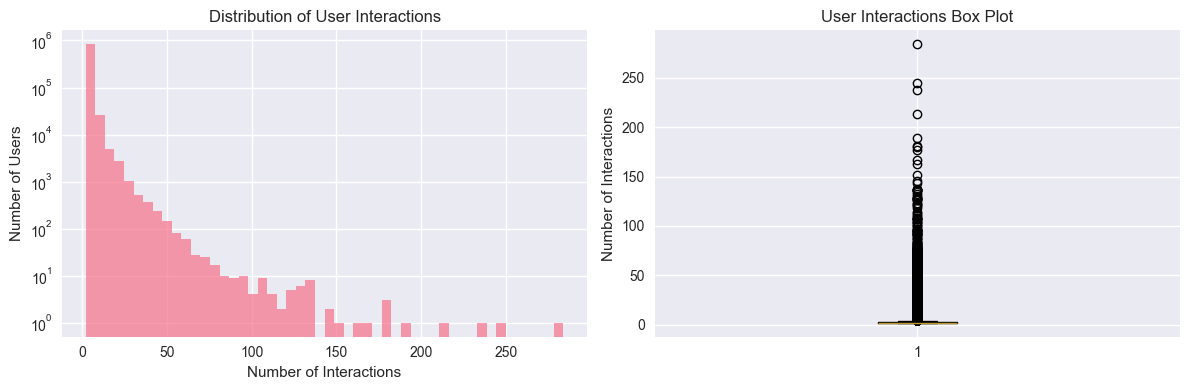


Popular items analysis (for cold start recommendations):
Top 20 most popular items:


,interaction_count,avg_rating,rating_std
item_id,,,
20832,28303,4.33,1.09
12595,22787,4.54,1.02
12372,16378,3.50,1.62
6864,15428,4.34,1.20
33154,14792,4.62,0.90
13451,13007,4.58,0.90
7030,12306,4.45,0.94
24931,12188,4.39,1.10
18550,11628,4.36,1.17



Temporal patterns for cold start recommendations:
Top 10 trending items (last 30 days):


item_id
70721    3
12595    3
27860    3
77706    3
75116    3
77526    2
69233    2
25732    2
75594    2
62547    2
dtype: int64

In [21]:
# Cold start problem analysis
print("=" * 60)
print("COLD START PROBLEM ANALYSIS")
print("=" * 60)

# Analyze new users and items in test set
train_users = set(train_df['user_id'].unique())
test_users = set(test_df['user_id'].unique())

print("User cold start analysis:")
print(f"Total users in training: {len(train_users):,}")
print(f"Total users in test: {len(test_users):,}")
print(f"Users appearing in both train and test: {len(train_users.intersection(test_users)):,}")
print(f"New users in test (cold start): {len(test_users - train_users):,}")
print(f"Cold start user percentage: {len(test_users - train_users) / len(test_users) * 100:.2f}%")

# Analyze user interaction patterns for cold start mitigation
print("\nUser interaction distribution (for warm start strategy):")
user_interaction_counts = train_df['user_id'].value_counts()
interaction_stats = user_interaction_counts.describe()
display(interaction_stats)

# Visualize user interaction distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(user_interaction_counts, bins=50, alpha=0.7)
plt.title('Distribution of User Interactions')
plt.xlabel('Number of Interactions')
plt.ylabel('Number of Users')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.boxplot(user_interaction_counts)
plt.title('User Interactions Box Plot')
plt.ylabel('Number of Interactions')

plt.tight_layout()
plt.show()

# Analyze items that could be recommended to cold start users
print("\nPopular items analysis (for cold start recommendations):")
popular_items = train_df.groupby('item_id').agg({
    'user_id': 'count',
    'rating': ['mean', 'std']
}).round(2)
popular_items.columns = ['interaction_count', 'avg_rating', 'rating_std']
popular_items = popular_items.sort_values('interaction_count', ascending=False)

print("Top 20 most popular items:")
display(popular_items.head(20))

# Analyze seasonal/temporal patterns for recommendations
if 'datetime' in train_df.columns:
    print("\nTemporal patterns for cold start recommendations:")
    recent_interactions = train_df[train_df['datetime'] >= train_df['datetime'].max() - pd.Timedelta(days=30)]
    recent_popular = recent_interactions.groupby('item_id').size().sort_values(ascending=False)
    
    print("Top 10 trending items (last 30 days):")
    display(recent_popular.head(10))


## 9. Sparsity Analysis


SPARSITY ANALYSIS
Number of users: 868,218
Number of items: 76,747
Number of interactions: 2,543,146
Maximum possible interactions: 66,633,126,846
Sparsity: 0.999962 (99.9962%)
Density: 0.000038 (0.0038%)

Creating user-item matrix sample...
Sample matrix shape: (49, 100)
Sample matrix sparsity: 0.9751


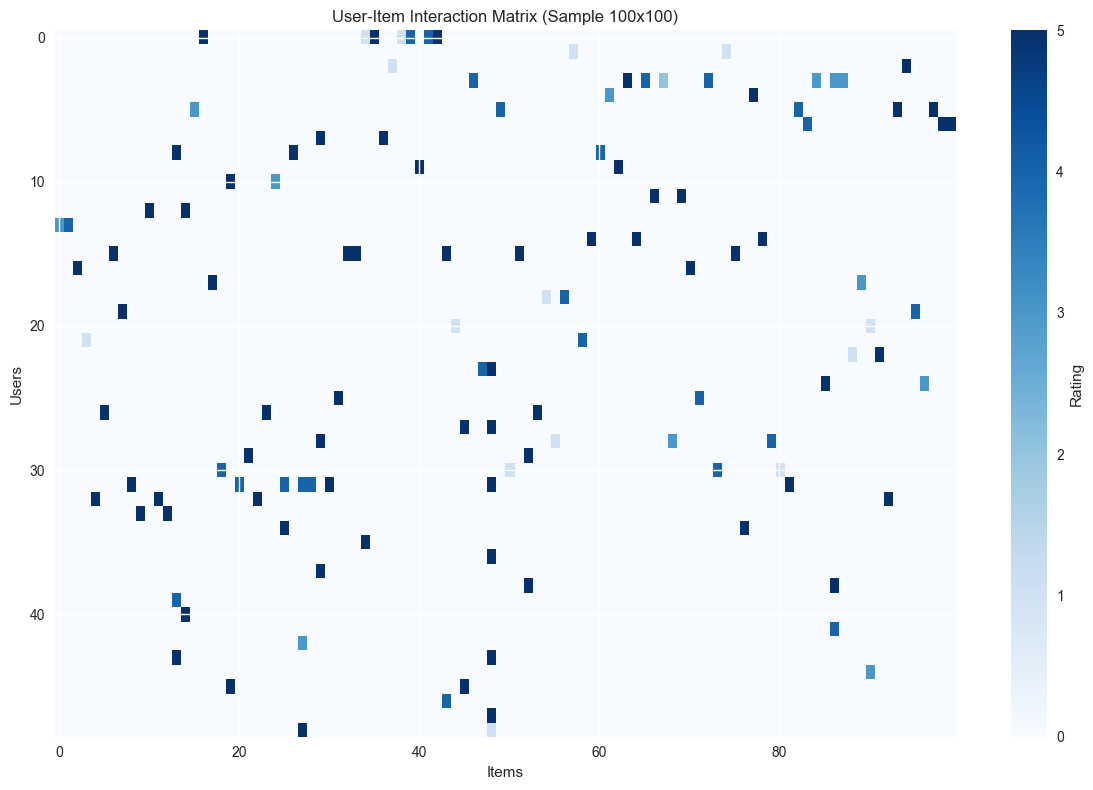


Sparsity by user activity segments:
   0-50th percentile: 0 users, sparsity: 1.0000
  50-90th percentile: 713,646 users, sparsity: 1.0000
  90-95th percentile: 108,435 users, sparsity: 0.9999
  95-99th percentile: 36,971 users, sparsity: 0.9997
  99-100th percentile: 9,165 users, sparsity: 0.9990

Long tail analysis:
Top 10% of items cover 98.2% of interactions
Top 20% of items cover 95.4% of interactions
Top 50% of items cover 96.9% of interactions


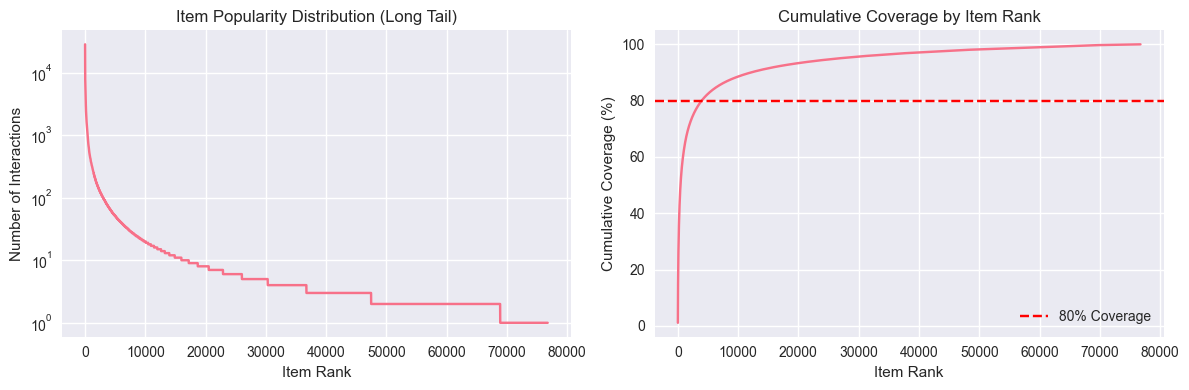

In [22]:
# Sparsity analysis
print("=" * 60)
print("SPARSITY ANALYSIS")
print("=" * 60)

# Calculate sparsity metrics
n_users = train_df['user_id'].nunique()
n_items = train_df['item_id'].nunique()
n_interactions = len(train_df)

# Theoretical maximum interactions
max_possible_interactions = n_users * n_items
sparsity = 1 - (n_interactions / max_possible_interactions)

print(f"Number of users: {n_users:,}")
print(f"Number of items: {n_items:,}")
print(f"Number of interactions: {n_interactions:,}")
print(f"Maximum possible interactions: {max_possible_interactions:,}")
print(f"Sparsity: {sparsity:.6f} ({sparsity*100:.4f}%)")
print(f"Density: {1-sparsity:.6f} ({(1-sparsity)*100:.4f}%)")

# Create user-item interaction matrix for visualization
print("\nCreating user-item matrix sample...")
# Take a sample for visualization (full matrix would be too large)
sample_users = train_df['user_id'].unique()[:100]
sample_items = train_df['item_id'].unique()[:100]

sample_interactions = train_df[
    (train_df['user_id'].isin(sample_users)) & 
    (train_df['item_id'].isin(sample_items))
]

# Create pivot table
interaction_matrix = sample_interactions.pivot_table(
    index='user_id', 
    columns='item_id', 
    values='rating',
    fill_value=0
)

print(f"Sample matrix shape: {interaction_matrix.shape}")
print(f"Sample matrix sparsity: {(interaction_matrix == 0).sum().sum() / interaction_matrix.size:.4f}")

# Visualize sparsity pattern
plt.figure(figsize=(12, 8))
plt.imshow(interaction_matrix.values, cmap='Blues', aspect='auto')
plt.title('User-Item Interaction Matrix (Sample 100x100)')
plt.xlabel('Items')
plt.ylabel('Users')
plt.colorbar(label='Rating')
plt.tight_layout()
plt.show()

# Analyze interaction density by user segments
print("\nSparsity by user activity segments:")
user_interaction_counts = train_df.groupby('user_id').size()

# Define user segments based on activity
percentiles = [0, 50, 90, 95, 99, 100]
thresholds = np.percentile(user_interaction_counts, percentiles)

for i in range(len(percentiles)-1):
    mask = (user_interaction_counts >= thresholds[i]) & (user_interaction_counts < thresholds[i+1])
    segment_users = user_interaction_counts[mask].index
    segment_data = train_df[train_df['user_id'].isin(segment_users)]
    
    segment_items = segment_data['item_id'].nunique()
    segment_interactions = len(segment_data)
    segment_max_interactions = len(segment_users) * segment_items
    segment_sparsity = 1 - (segment_interactions / segment_max_interactions) if segment_max_interactions > 0 else 1
    
    print(f"  {percentiles[i]:2.0f}-{percentiles[i+1]:2.0f}th percentile: "
          f"{len(segment_users):,} users, "
          f"sparsity: {segment_sparsity:.4f}")

# Long tail analysis for items
print("\nLong tail analysis:")
item_popularity = train_df['item_id'].value_counts().sort_values(ascending=False)

# Calculate cumulative coverage
cumulative_interactions = item_popularity.cumsum()
total_interactions = cumulative_interactions.iloc[-1]

print(f"Top 10% of items cover {cumulative_interactions[int(len(item_popularity)*0.1)] / total_interactions * 100:.1f}% of interactions")
print(f"Top 20% of items cover {cumulative_interactions[int(len(item_popularity)*0.2)] / total_interactions * 100:.1f}% of interactions")
print(f"Top 50% of items cover {cumulative_interactions[int(len(item_popularity)*0.5)] / total_interactions * 100:.1f}% of interactions")

# Visualize long tail
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(len(item_popularity)), item_popularity.values)
plt.title('Item Popularity Distribution (Long Tail)')
plt.xlabel('Item Rank')
plt.ylabel('Number of Interactions')
plt.yscale('log')

plt.subplot(1, 2, 2)
coverage_pct = cumulative_interactions / total_interactions * 100
plt.plot(range(len(item_popularity)), coverage_pct.values)
plt.title('Cumulative Coverage by Item Rank')
plt.xlabel('Item Rank')
plt.ylabel('Cumulative Coverage (%)')
plt.axhline(y=80, color='r', linestyle='--', label='80% Coverage')
plt.legend()

plt.tight_layout()
plt.show()


## 10. Test Set Analysis


TEST SET ANALYSIS
Test set shape: (412461, 2)
Test set columns: ['user_id', 'predictions']

Test user analysis:
Number of test users: 412,461
Test users also in training: 412,461
New test users (cold start): 0

Existing test users behavior in training:
Statistics for existing test users:


,num_interactions,avg_rating,rating_std
count,412461.000000,412461.000000,412461.000000
mean,3.955846,4.074688,0.796459
std,4.219538,0.976720,0.805580
min,2.000000,1.000000,0.000000
25%,2.000000,3.500000,0.000000
50%,3.000000,4.330000,0.690000
75%,4.000000,5.000000,1.410000
max,284.000000,5.000000,2.830000



Comparison with all training users:
Existing test users - Mean interactions: 3.96
All training users - Mean interactions: 2.93
Existing test users - Mean rating: 4.07
All training users - Mean rating: 4.05

Sample submission analysis:
Sample submission shape: (412461, 2)
Sample submission columns: ['user_id', 'predictions']
Items per user (sample): 10
Sample predictions: 50727 25161 70745 64522 3476 5270 67819 59047 9548 20616

Prediction lengths distribution:


predictions
10    412461
Name: count, dtype: int64


Most recommended items in sample submission:


42820    2
41039    2
47281    2
39853    2
25513    2
3295     2
59826    2
59396    2
42808    1
41427    1
Name: count, dtype: int64


Prediction items validation:
Unique items in sample predictions: 992
Prediction items also in training: 992
Prediction items not in training: 0


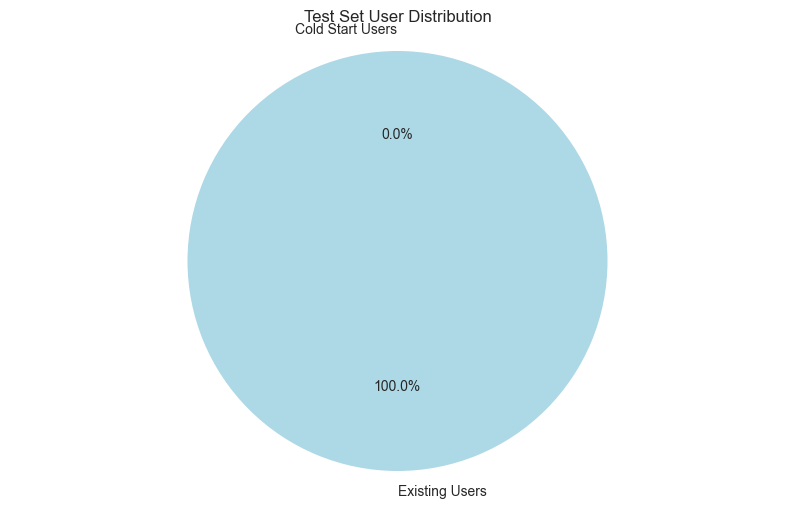

In [23]:
# Test set analysis
print("=" * 60)
print("TEST SET ANALYSIS")
print("=" * 60)

print(f"Test set shape: {test_df.shape}")
print(f"Test set columns: {list(test_df.columns)}")

# Analyze test users
test_users = set(test_df['user_id'].unique())
train_users = set(train_df['user_id'].unique())

print(f"\nTest user analysis:")
print(f"Number of test users: {len(test_users):,}")
print(f"Test users also in training: {len(test_users.intersection(train_users)):,}")
print(f"New test users (cold start): {len(test_users - train_users):,}")

# For users that exist in training, analyze their behavior
existing_test_users = test_users.intersection(train_users)
if len(existing_test_users) > 0:
    existing_user_data = train_df[train_df['user_id'].isin(existing_test_users)]
    
    print(f"\nExisting test users behavior in training:")
    existing_user_stats = existing_user_data.groupby('user_id').agg({
        'item_id': 'count',
        'rating': ['mean', 'std']
    }).round(2)
    existing_user_stats.columns = ['num_interactions', 'avg_rating', 'rating_std']
    
    print("Statistics for existing test users:")
    display(existing_user_stats.describe())
    
    # Compare with all training users
    all_user_stats = train_df.groupby('user_id').agg({
        'item_id': 'count',
        'rating': ['mean', 'std']
    }).round(2)
    all_user_stats.columns = ['num_interactions', 'avg_rating', 'rating_std']
    
    print(f"\nComparison with all training users:")
    print(f"Existing test users - Mean interactions: {existing_user_stats['num_interactions'].mean():.2f}")
    print(f"All training users - Mean interactions: {all_user_stats['num_interactions'].mean():.2f}")
    print(f"Existing test users - Mean rating: {existing_user_stats['avg_rating'].mean():.2f}")
    print(f"All training users - Mean rating: {all_user_stats['avg_rating'].mean():.2f}")

# Analyze submission format
print(f"\nSample submission analysis:")
print(f"Sample submission shape: {sample_submission.shape}")
print(f"Sample submission columns: {list(sample_submission.columns)}")

# Analyze prediction format
if 'predictions' in sample_submission.columns:
    # Parse predictions to see how many items are recommended per user
    sample_predictions = sample_submission['predictions'].iloc[0]
    prediction_items = sample_predictions.split()
    print(f"Items per user (sample): {len(prediction_items)}")
    print(f"Sample predictions: {sample_predictions}")
    
    # Check if all predictions have the same format
    prediction_lengths = sample_submission['predictions'].apply(lambda x: len(x.split())).value_counts()
    print(f"\nPrediction lengths distribution:")
    display(prediction_lengths)
    
    # Analyze what items appear in sample predictions
    all_prediction_items = []
    for pred in sample_submission['predictions'].head(100):  # Sample to avoid memory issues
        all_prediction_items.extend(pred.split())
    
    prediction_item_counts = pd.Series(all_prediction_items).value_counts()
    print(f"\nMost recommended items in sample submission:")
    display(prediction_item_counts.head(10))
    
    # Check if prediction items exist in training
    train_items = set(train_df['item_id'].astype(str).unique())
    prediction_items_set = set(all_prediction_items)
    
    print(f"\nPrediction items validation:")
    print(f"Unique items in sample predictions: {len(prediction_items_set)}")
    print(f"Prediction items also in training: {len(prediction_items_set.intersection(train_items))}")
    print(f"Prediction items not in training: {len(prediction_items_set - train_items)}")

# Visualize test vs train user overlap
plt.figure(figsize=(10, 6))
labels = ['Cold Start Users', 'Existing Users']
sizes = [len(test_users - train_users), len(test_users.intersection(train_users))]
colors = ['lightcoral', 'lightblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Test Set User Distribution')
plt.axis('equal')
plt.show()


## 11. Key Insights and Recommendations


In [ ]:
#TODO: TO WRITE DOWN THE KEY INSIGHTS AND RECOMMENDATIONS

List of crucial insights and :